# 📊📚 Analysez des données de systèmes éducatifs

## Sommaire
[Introduction](#Introduction)  

[1. Librairies et chargement des data](#1.-Librairies-et-chargement-des-data)
- [a. Librairies importées](#a.-Librairies-importees)
- [b. Chargement des fichiers CSV](#b.-Chargement-des-fichiers-CSV)

[2. Nettoyage des dataframes](#2.-Nettoyage-des-dataframes)
- [a. Création du log df](#a.-Creation-du-log-df)
- [b. Suppression des colonnes avec na_rate = 1](#b.-Suppression-des-colonnes-avec-na_rate-=-1)
- [c. Suppression des faux pays](#c.-Suppression-des-faux-pays)

[3. Sélection des indicateurs et des années](#3.-Selection-des-indicateurs-et-des-annees)
- [a. Sélection des thèmes](#a.-Selection-des-themes)
- [b. Sélection des années](#b.-Selection-des-annees)
- [c. Répartition des valeurs nulles](#c.-Repartition-des-valeurs-nulles)
- [d. Sélection grosse maille](#d.-Selection-grosse-maille-des-indicateurs)
- [e. Matrice des corrélation et sélection finale des kpis](#e.-Matrice-des-correlation-et-selection-finale-des-kpis)

[4. ACP](#4.-ACP)
- [a. Normalisation des données](#a.-Normalisation-des-donnees)
- [b. Variance expliquée](#b.-Variance-expliquee)
- [c. Cercle des corrélations](#c.-Cercle-des-correlations)
- [d. Représentation graphique de l'ACP](#d.-Representation-graphique-de-l'ACP)

[Conclusion](#Conclusion)

## Introduction

Academy est une plateforme d'éducation en ligne pour les étudiants du niveau lycée et université.
La start-up qui a développé la plateforme souhaite l'étendre à un niveau international. 

Pour ce faire, il faut dans un premier temps **s'assurer que les données récoltées de la banque mondiale sont exploitables** pour enrichir la réflexion. 
Puis, dans un second temps, **identifier les pays cibles avec un fort potentiel** et voir leur évolution dans le temps.

## 1. Librairies et chargement des data

### a. Librairies importees

In [27]:
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

### b. Chargement des fichiers CSV

In [28]:
df_data = pd.read_csv('../dataset/EdStatsData.csv')
df_country_series = pd.read_csv('../dataset/EdStatsCountry-Series.csv')
df_country = pd.read_csv('../dataset/EdStatsCountry.csv')
df_foot_note = pd.read_csv('../dataset/EdStatsFootNote.csv')
df_stats_series = pd.read_csv('../dataset/EdStatsSeries.csv')

###### Description des DF

**df_data** : Ensemble des indicateurs par pays et par années (1970 à 2100). Chaque ligne représente le couple pays/indicateurs.

**df_country** : Liste d'informations complémentaires concernant les pays. Chaque ligne correspond à un pays.

**df_country_series** : Indicateurs démographiques et économiques par année et par pays présents dans df_data. Chaque ligne repésente le couples pays/indicateurs/années.

**df_stats_series** : Lexique des indicateurs. Chaque ligne correspond à un indicateur.

**df_foot_note** : Informations additionnelles sur les indicateurs basées sur l'année, le type d'indicateur et le pays dans df_data.

## 2. Nettoyage des dataframes

### a. Creation du log df 

In [29]:
#Log df infos
dic = {"df_data" : df_data, "df_country":df_country, "df_country_series" : df_country_series, 
           "df_foot_note" : df_foot_note, "df_stats_series" : df_stats_series}


cat_log = ['shape','duplicated_rows','na_rate', 'stats','nunique_cat']

obj_log = {
    'log_cat': cat_log,
    "df_data": [None] * len(cat_log),
    "df_country": [None] * len(cat_log),
    "df_country_series": [None] * len(cat_log),
    "df_foot_note": [None] * len(cat_log),
    "df_stats_series": [None] * len(cat_log)
}

df_log = pd.DataFrame(obj_log)

In [30]:
dic_keys = list(dic.keys())

for df_name in dic_keys:
    
    #Shape
    shape_value = dic[df_name].shape
    df_log.loc[df_log['log_cat'] == 'shape', df_name] = [shape_value]
    
    #duplicated_rows
    duplicates = dic[df_name].duplicated().sum()
    df_log.loc[df_log['log_cat'] == 'duplicated_rows', df_name] = [duplicates]
    
    #na_rate
    na_rate = round(dic[df_name].isna().sum() / len(dic[df_name]),2)
    df_log.loc[df_log['log_cat'] == 'na_rate', df_name] = [na_rate]
    
    #stats df.describe(include=[np.number])
    stats_report = dic[df_name].describe(include=[np.number])
    df_log.loc[df_log['log_cat'] == 'stats', df_name] = [stats_report]
    
    #Nb uniques categories df_obj = df.select_dtypes(include='object')
    unique_categories = dic[df_name].select_dtypes(include='object').nunique()
    df_log.loc[df_log['log_cat'] == 'nunique_cat', df_name] = [unique_categories]

In [31]:
df_log

,log_cat,df_data,df_country,df_country_series,df_foot_note,df_stats_series
0,shape,"(886930, 70)","(241, 32)","(613, 4)","(643638, 5)","(3665, 21)"
1,duplicated_rows,0,0,0,0,0
2,na_rate,Country Name 0.00 Country Code 0.00 ...,Country Code ...,CountryCode 0.0 SeriesCode 0.0 DESCRIPT...,CountryCode 0.0 SeriesCode 0.0 Year ...,Series Code 0.00 To...
3,stats,1970 1971 197...,National accounts reference year Lates...,Unnamed: 3 count 0.0 mean ...,Unnamed: 4 count 0.0 mean ...,Unit of measure Notes from original so...
4,nunique_cat,Country Name 242 Country Code 242 ...,Country Code ...,CountryCode 211 SeriesCode 21 DESCRIPT...,CountryCode 239 SeriesCode 1558 Year ...,Series Code 3665 To...


In [32]:
# Widgets : Toggle pour log_cat et Toggle pour les colonnes
toggle_cat = widgets.ToggleButtons(
    options=df_log['log_cat'].values,
    description='Category:',
    button_style=''
)

toggle_df = widgets.ToggleButtons(
    options=df_log.columns[1:],
    description='Dataframe:',
    button_style=''
)

# Output widget pour afficher le résultat
out = widgets.Output()

# Callback qui combine les deux sélections
def update_value(change):
    category_name = toggle_cat.value
    df_name = toggle_df.value
    
    with out:
        out.clear_output()
        try:
            valeur = df_log.loc[df_log['log_cat'] == category_name, df_name].iloc[0]
            
            if isinstance(valeur, pd.Series):
                display(valeur.to_frame())
            else:
                display(valeur)
                
        except Exception as e:
            print("Erreur :", e)

# Observer les changements sur les deux widgets
toggle_cat.observe(update_value, names='value')
toggle_df.observe(update_value, names='value')

# Affichage
display(toggle_cat, toggle_df, out)

ToggleButtons(description='Category:', options=('shape', 'duplicated_rows', 'na_rate', 'stats', 'nunique_cat')…

ToggleButtons(description='Dataframe:', options=('df_data', 'df_country', 'df_country_series', 'df_foot_note',…

Output()

### b. Suppression des colonnes avec na_rate = 1

In [33]:
if df_data.loc[:,['Country Name','Indicator Name']].duplicated().sum() == 0:
    print('✅ Pas de doublon pour le couple Pays/Indicateurs dans le df_data')

✅ Pas de doublon pour le couple Pays/Indicateurs dans le df_data


In [34]:
col_to_delete = []

for df_name in dic_keys:
    temp_df = df_log.loc[df_log['log_cat'] == "na_rate", df_name].iloc[0].reset_index()
    
    #col name
    new_col_name = ['col_name','na_rate']
    temp_df.columns = new_col_name
    temp_df_filtered = temp_df[temp_df['na_rate'] == 1]
    col_list = temp_df_filtered['col_name'].astype(str).tolist()
    
    for col in col_list:
        col_to_delete.append(col)

print(col_to_delete)

['2017', 'Unnamed: 69', 'Unnamed: 31', 'Unnamed: 3', 'Unnamed: 4', 'Unit of measure', 'Limitations and exceptions', 'Notes from original source', 'General comments', 'Development relevance', 'Other web links', 'Related indicators', 'License Type', 'Unnamed: 20']


In [35]:
col_to_delete_set = set(col_to_delete)

for df_name in dic_keys:
    col_to_keep = [x for x in dic[df_name].columns if x not in col_to_delete_set]
    dic[df_name] = dic[df_name][col_to_keep]

### c. Suppression des faux pays

In [36]:
region_to_delete = ['Arab World','East Asia & Pacific (developing only)',
       'East Asia & Pacific (all income levels)',
       'Europe & Central Asia (developing only)',
       'Europe & Central Asia (all income levels)','Euro area','European Union','High income',
       'Heavily indebted poor countries (HIPC)','Latin America & Caribbean (developing only)',
       'Latin America & Caribbean (all income levels)',
       'Least developed countries: UN classification', 'Low income','Lower middle income',
       'Low & middle income','Middle East & North Africa (all income levels)','Middle income',
       'OECD members','Sub-Saharan Africa (developing only)','Sub-Saharan Africa (all income levels)',
       'Middle East & North Africa (developing only)',
       'World','Latin America & Caribbean',
       'Middle East & North Africa (excluding high income)',
       'North America', 'South Asia', 'Upper middle income',]

In [37]:
df_region = df_country[df_country['Short Name'].isin(region_to_delete)]
df_region = df_region.loc[:,['Short Name','Country Code']]

In [38]:
dic['df_country_series'] = dic['df_country_series'].rename(columns={'CountryCode' : 'Country Code'})
dic['df_foot_note'] = dic['df_foot_note'].rename(columns={'CountryCode' : 'Country Code'})

In [39]:
for df_name in dic_keys:
    if df_name != 'df_stats_series':
        dic[df_name] = dic[df_name][~dic[df_name]['Country Code'].isin(df_region['Country Code'].unique())]

## 3. Selection des indicateurs et des annees

**Critères de recherches.**

il faudrait que les pays :

 - aient une accessibilité restreinte du niveau secondaire et universitaire. Soit par:
     - un manque d'infrastructure
     - un manque de personnel
     - réservé à une certaine population (classe sociale, genre...).
 - aient une population jeune avec une demande forte pour léducation (% de diplômé faible par rapport à la population en âge de l'être).
 - soient un minimum développé de sorte à ce que les étudiants puissent se procurer le matériel informatique adéquat.

**Pourquoi ?** 

✅ Opportunité de proposer une alternative.

✅ Cette proposition est viable s'il y a de la demande.

✅ Et cette dernière doit avoir les moyens d'accéder au produit.

### a. Selection des themes

In [40]:
# Identification des topics
dic_kpis = {
    'School accessibility': {
        'Teachers': [],
        'Attainment': [],
        'Literacy' : [],
},
    'Demography': {
        'Population': [],
        'Health: Population: Structure' : [],
        'Health: Population: Dynamics': []
    },
    'Technology': {
        'Infrastructure: Communications': []
    },
    'Economy': {
        'Economic Policy & Debt: Purchasing power parity' : [],  
    },
    'Social': {
        'Social Protection & Labor: Unemployment': [],
    }
}

In [41]:
# Stockage des thèmes
topic_list = []
for theme in dic_kpis:
    for topic in dic_kpis[theme]:
        topic_list.append(topic)

In [42]:
# Filtrage des données
dic['df_data'] = pd.merge(dic['df_data'],dic['df_stats_series'].loc[:,['Topic', 'Indicator Name']], how='left', on='Indicator Name')
dic['df_data'] = dic['df_data'][dic['df_data']['Topic'].isin(topic_list)]

### b. Selection des annees

In [43]:
years = ['2000', '2001', '2002', '2003', '2004', '2005',
       '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014',
       '2015', '2016', '2020', '2025', '2030']

str_col = ['Country Name', 'Country Code', 'Topic','Indicator Name', 'Indicator Code']

dic['df_data'] = dic['df_data'].loc[:,str_col + years]

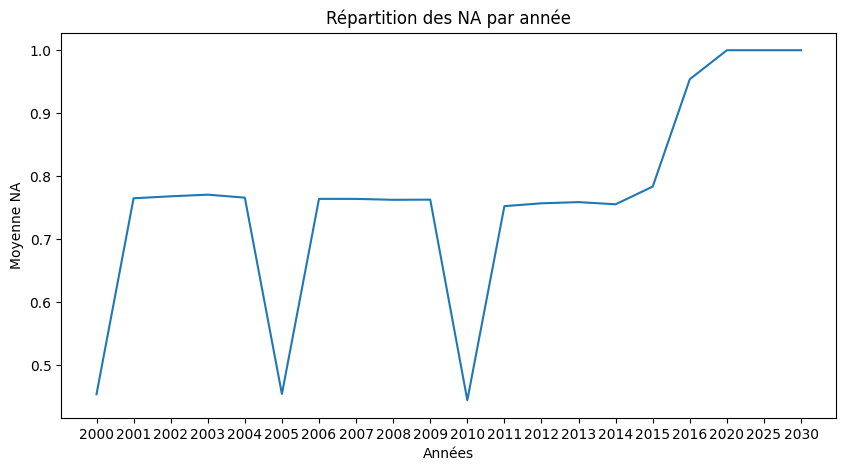

In [44]:
x = np.array(years)
y = np.array(dic['df_data'][years].isna().mean().values)
plt.figure(figsize=(10, 5)) 
plt.plot(x, y)

plt.xlabel("Années")
plt.ylabel("Moyenne NA")

plt.title("Répartition des NA par année")

plt.show()

Les années à conserver sont 2000, 2005 et 2010 car elles ont le moins de valeurs nulles.

In [45]:
years_to_keep = ['2000','2005','2010']
dic['df_data'] = dic['df_data'].loc[:,str_col + years_to_keep] 

### c. Repartition des valeurs nulles

In [46]:
dic['df_data'].groupby(['Topic']).agg({'Indicator Name':'nunique'}).reset_index().sort_values('Indicator Name', ascending=False)

,Topic,Indicator Name
0,Attainment,425
6,Population,161
7,Teachers,137
5,Literacy,32
1,Economic Policy & Debt: Purchasing power parity,6
3,Health: Population: Structure,5
4,Infrastructure: Communications,2
2,Health: Population: Dynamics,1


In [47]:
dic['df_data'][years_to_keep].isna().mean()

2000    0.453842
2005    0.454196
2010    0.444314
dtype: float64

In [48]:
df_na_rate = dic['df_data'].groupby(['Topic','Indicator Name'])[years_to_keep].apply(lambda x: x.isna().mean()).reset_index()
df_na_rate['mean_rate_total'] = df_na_rate[["2000", "2005", "2010"]].mean(axis=1)
df_na_rate = df_na_rate.sort_values('mean_rate_total', ascending=True)

In [49]:
df_na_rate.head(5)

,Topic,Indicator Name,2000,2005,2010,mean_rate_total
436,Health: Population: Structure,"Population, total",0.009217,0.009217,0.009217,0.009217
431,Health: Population: Dynamics,Population growth (annual %),0.009217,0.009217,0.009217,0.009217
437,Infrastructure: Communications,Internet users (per 100 people),0.096774,0.087558,0.069124,0.084485
432,Health: Population: Structure,"Population, female",0.105991,0.105991,0.105991,0.105991
435,Health: Population: Structure,"Population, male (% of total)",0.105991,0.105991,0.105991,0.105991


### d. Selection grosse maille des indicateurs

In [50]:
# Identification des indicateurs
dic_kpis = {
    'School accessibility': {
        'Teachers': ['Teachers in primary education, both sexes (number)',
                    'Teachers in secondary education, both sexes (number)',
                    'Teachers in tertiary education programmes, both sexes (number)'],
        'Attainment': ['Barro-Lee: Percentage of population age 15+ with no education',
                       'Barro-Lee: Percentage of population age 35-39 with no education',
                      'Barro-Lee: Percentage of population age 55-59 with no education',
                      ],
        'Literacy' : ['Adult illiterate population, 15+ years, both sexes (number)'],
},
    'Demography': {
        'Population': ['Population of the official age for upper secondary education, both sexes (number)',
                       'Population of the official age for tertiary education, both sexes (number)',
                       'Population of the official age for secondary education, both sexes (number)',
                       'Population of the official age for lower secondary education, both sexes (number)',
                       ],
        'Health: Population: Structure': ['Population, total'],
        'Health: Population: Dynamics': ['Population growth (annual %)']
    },
    'Technology': {
        'Infrastructure: Communications': ['Internet users (per 100 people)',
                                           'Personal computers (per 100 people)']
    },
    'Economy': {
        'Economic Policy & Debt: Purchasing power parity' : ['GDP, PPP (constant 2011 international $)',
                                                             'GDP per capita, PPP (constant 2011 international $)',
                                                             'GDP, PPP (current international $)',
                                                             'GDP per capita, PPP (current international $)',
                                                             'GNI per capita, PPP (current international $)',
                                                             'GNI, PPP (current international $)'],  
    },
}

In [51]:
kpis_list = []
for theme in dic_kpis:
    for topic in dic_kpis[theme]:
        for kpi in dic_kpis[theme][topic]:
            kpis_list.append(kpi)

df_data_temp = dic['df_data'][dic['df_data']['Indicator Name'].isin(kpis_list)]

In [52]:
df_data_temp['mean_col'] = df_data_temp[["2000", "2005", "2010"]].mean(axis=1)
df_data_temp = df_data_temp.loc[:,str_col + ['mean_col']]

C:\Users\nnaoui.BMIGROUP\AppData\Local\Temp\ipykernel_2872\492771273.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_temp['mean_col'] = df_data_temp[["2000", "2005", "2010"]].mean(axis=1)


### e. Matrice des correlation et selection finale des kpis

In [53]:
df_data_final = df_data_temp.loc[:,['Country Name']].drop_duplicates()

for indicator in df_data_temp['Indicator Name'].unique():
    df_temp = df_data_temp[df_data_temp['Indicator Name'] == indicator]
    df_temp = df_temp.rename(columns={'mean_col' : indicator})
    df_data_final = pd.merge(df_data_final, df_temp.loc[:,['Country Name', indicator]], how='left', on='Country Name')

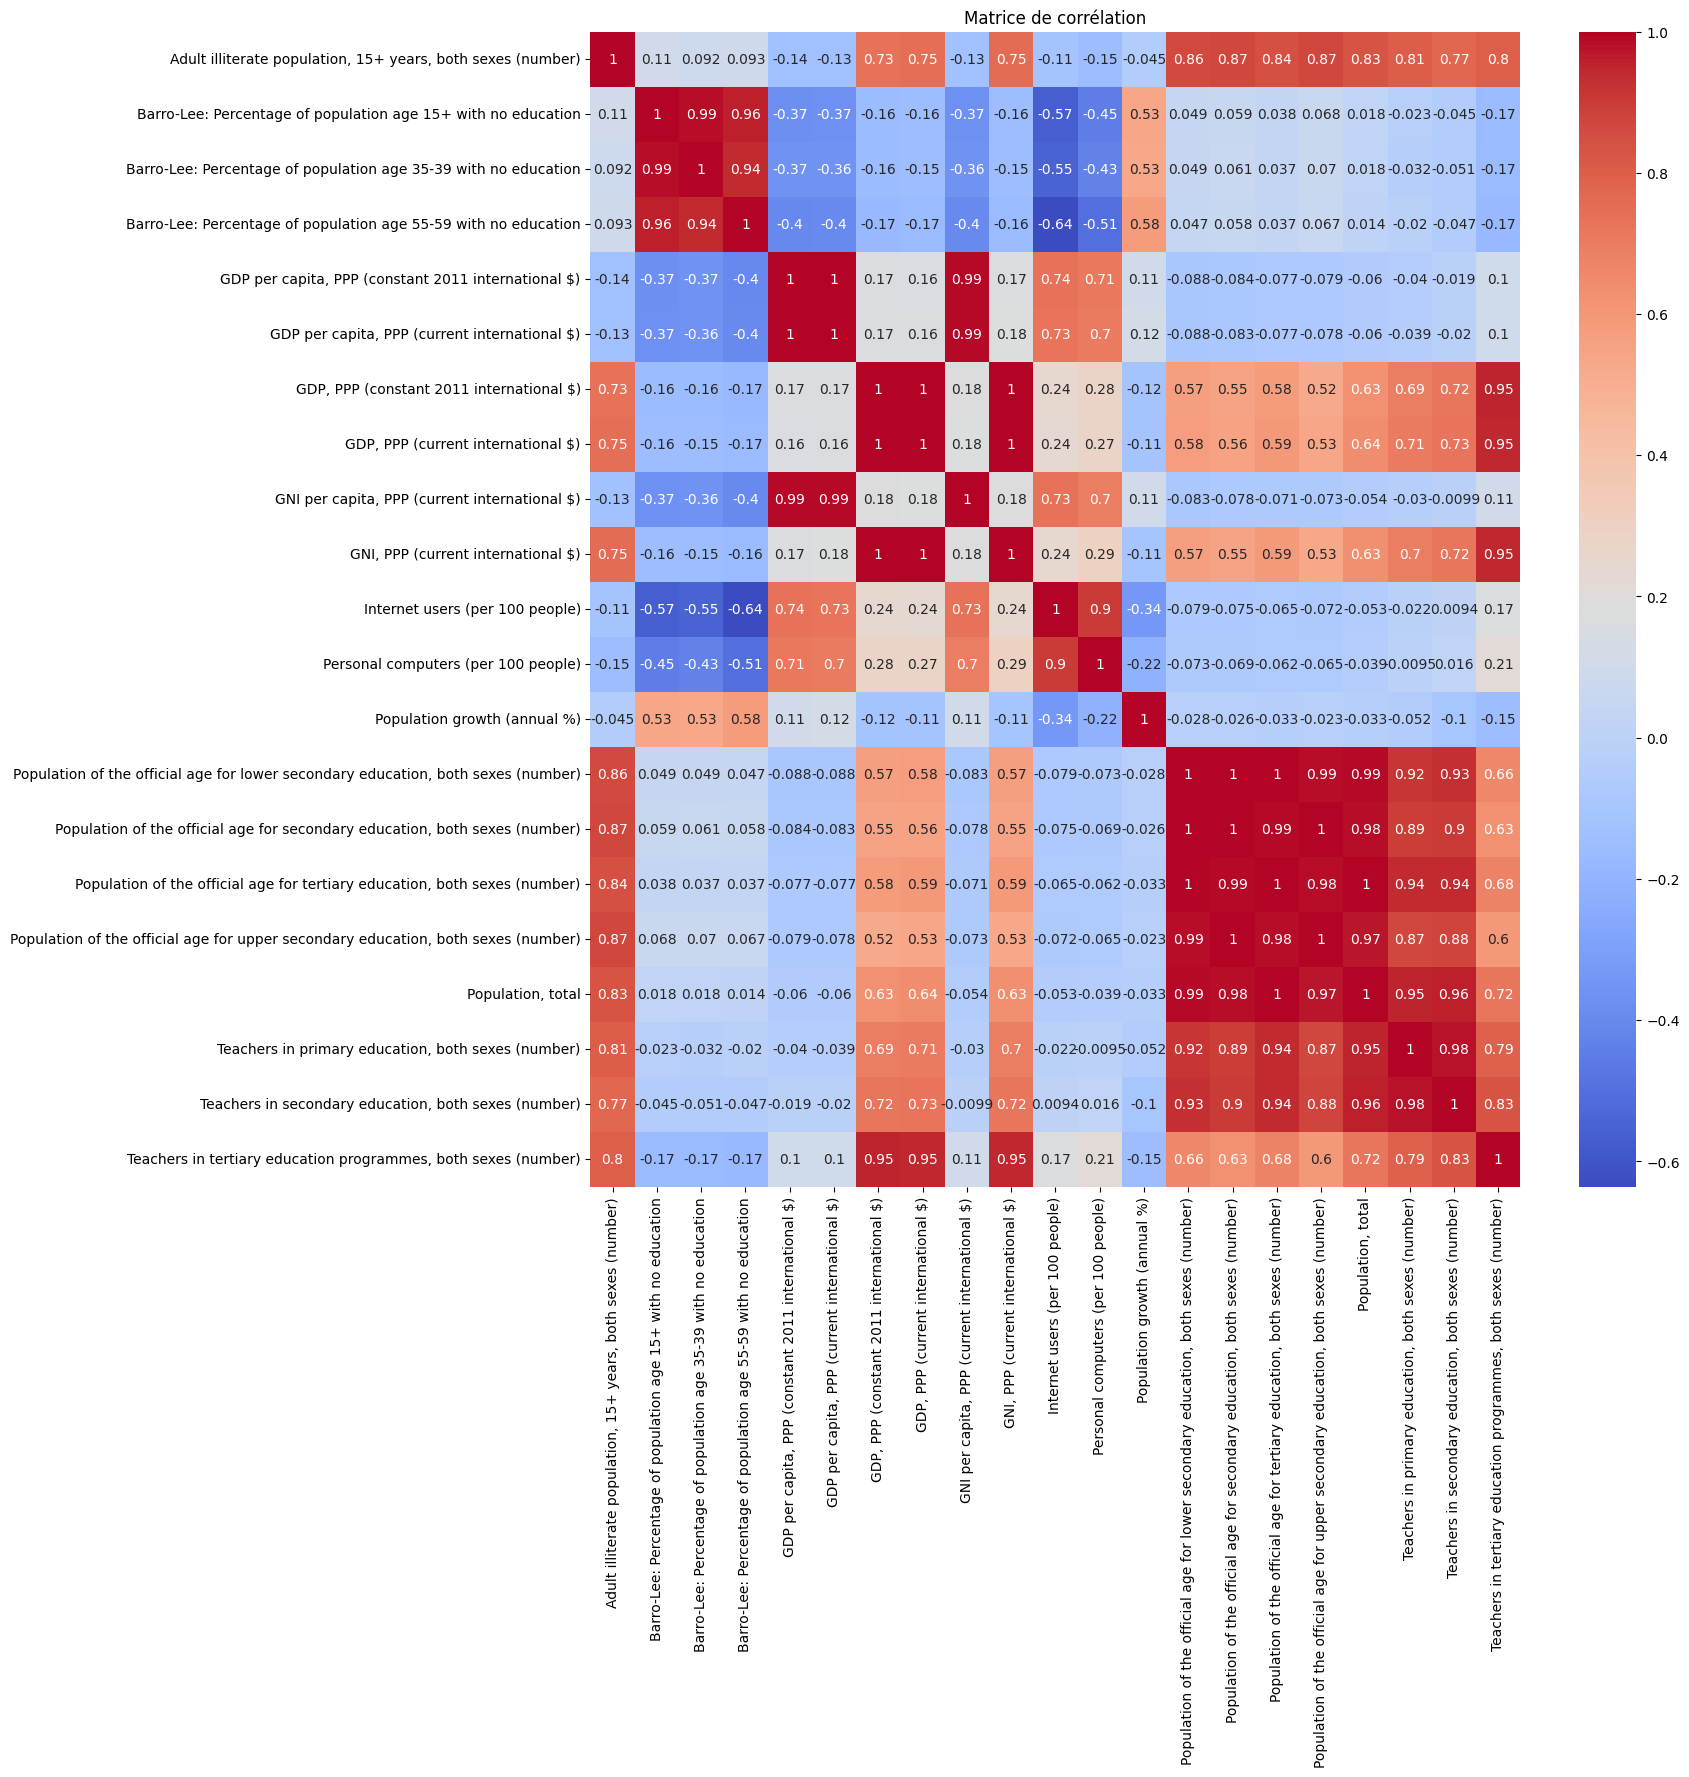

In [54]:
# Calcul de la corrélation
corr = df_data_final.drop(columns=['Country Name']).corr()

# Définir la taille de la figure avant de tracer
plt.figure(figsize=(15, 15))

# Créer la heatmap
sns.heatmap(corr, annot=True, cmap="coolwarm")

# Ajouter un titre si besoin
plt.title("Matrice de corrélation", fontsize=12)

plt.show()

In [55]:
dic_kpis = {
    'School accessibility': {
        'Teachers': [
            'Teachers in secondary education, both sexes (number)',
        ],
        'Attainment': [
            'Barro-Lee: Percentage of population age 15+ with no education',
        ],
    },
    'Demography': {
        'Population': [
            'Population of the official age for secondary education, both sexes (number)',
        ],
        'Health: Population: Structure' : ['Population, total']
        ,
        'Health: Population: Dynamics': [
            'Population growth (annual %)'
        ]
    },
    'Technology': {
        'Infrastructure: Communications': [
            'Internet users (per 100 people)',
        ]
    },
    'Economy': {
        'Economic Policy & Debt: Purchasing power parity': [
            'GNI per capita, PPP (current international $)',
        ]
    }
}


In [56]:
kpis_list = []
for theme in dic_kpis:
    for topic in dic_kpis[theme]:
        for kpi in dic_kpis[theme][topic]:
            kpis_list.append(kpi)

df_data_final = df_data_final.loc[:,['Country Name'] + kpis_list]

## 4. ACP

### a. Normalisation des donnees

In [31]:
df_data_final['Prospect (per 100 people)'] = round(df_data_final['Population of the official age for secondary education, both sexes (number)'] /
                                             df_data_final['Population, total'] * 100,0)

df_data_final['Prospect no educated (per 100 people)'] = round(df_data_final['Population of the official age for secondary education, both sexes (number)'] *
                                                               (df_data_final['Barro-Lee: Percentage of population age 15+ with no education']/100) /
                                                               df_data_final['Population, total'] * 100,3)

df_data_final['Teachers (per 100 prospect)'] = round(df_data_final['Teachers in secondary education, both sexes (number)'] /
                                                     df_data_final['Population of the official age for secondary education, both sexes (number)'] * 100,0)

In [32]:
df_data_final = df_data_final.loc[:,['Country Name','Prospect (per 100 people)','Prospect no educated (per 100 people)','Teachers (per 100 prospect)',
                                     'Population growth (annual %)','Internet users (per 100 people)','GNI per capita, PPP (current international $)']]

In [59]:
df_data_final = df_data_final.dropna()

### b. Variance expliquee

In [34]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_data_final.drop(columns=['Country Name']))

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Variance expliquée :", pca.explained_variance_ratio_)

Variance expliquée : [0.6299456  0.20579535]


### c. Cercle des correlations

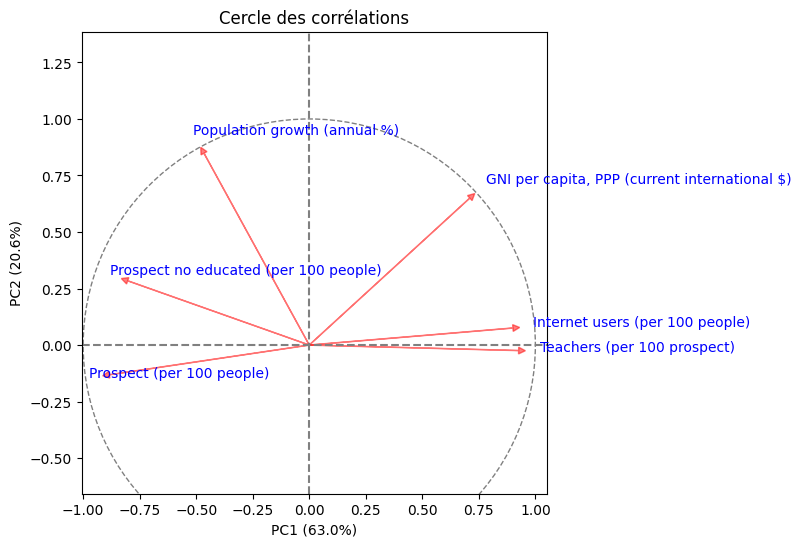

In [35]:
# Récupération des composantes
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Noms des variables
features = df_data_final.drop(columns=['Country Name']).columns

# Tracer le cercle
plt.figure(figsize=(6,6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')

for i, feature in enumerate(features):
    plt.arrow(0, 0, loadings[i,0], loadings[i,1],
              color='r', alpha=0.5, head_width=0.03, head_length=0.03)
    plt.text(loadings[i,0]*1.1, loadings[i,1]*1.1, feature, color='b')

# Cercle unité
circle = plt.Circle((0,0), 1, color='gray', fill=False, linestyle='--')
plt.gca().add_artist(circle)

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("Cercle des corrélations")
plt.axis('equal')
plt.show()

**Interprétation des axes**

- PC1 rend compte de 63% de la vairance totale, ce qui en fait l'axe le plus important.
- PC2 quant à lui représente 20% de la variance totale.

Plus le vecteur d'une variable est proche d'un axe, plus cette variable contribue à la composante principale.

**Interprétation des variables**

- Les variables GNI, Internet users et Teachers sont fortement corrélées entre elles et de manière positive de par la direction des fléches sur l'axe.
- Elles indiquent également qu'elles sont fortement représentées en vue de la longueur des flèches.
- Cela montre que les pays avec un GNI par habitant plus élevé ont tendance à avoir plus d'utilisateurs d'internet.
Et également l'offre en terme de professeurs est plus importante.
- Les variables pointant dans des directions opposées sont négativement corrélées. C'est le cas de Popolation growth et Prospect no educated qui sont négativement corrélés avec GNI et Internet users. Cela signifie qu'à mesure que le GNI par habitant et l'utilisation d'internet augmentent, la croissance démographique et le pourcentage d'élèves non éduqués diminuent.

**Principales relations**

- L'axe PC1 semble repésenter une dimension de développement économique et social. Avec les variables "GNI", "Internet users" et "Teachers".
- L'axe PC2 quant à lui semble représenter une dimension de la situation des étudiants. Les vecteurs "Population growth" et "Prospect no educated" pointent vers le haut, ce qui suggère qu'ils sont positivement corrélés entre eux, mais négativement corrélés avec les variables situées sur le côté droit de PC1. Par ailleurs, le fait que le vecteur "Prospect" soit dans la direction opposée à celle du vecteur "Teachers" sur PC1 pourrait impliquer une relation négative, ce qui signifierait qu'un nombre plus élevé d'étudiants pourrait être associé à un nombre plus faible d'enseignants par étudiant.

En résumé, ce cercle de corrélation montre deux grands groupes de variables : celles liées au progrès économique et technologique (GNI, Internet users, Teachers) et celles liées à la démographie et à l'éducation (Population growth, Prospect no educated). Le graphique visualise une opposition claire entre ces deux groupes, ce qui suggère que les pays avec un GNI et une utilisation d'Internet plus élevés ont tendance à avoir une croissance démographique plus faible et moins d'étudiants non éduqués.


### d. Representation graphique de l'ACP

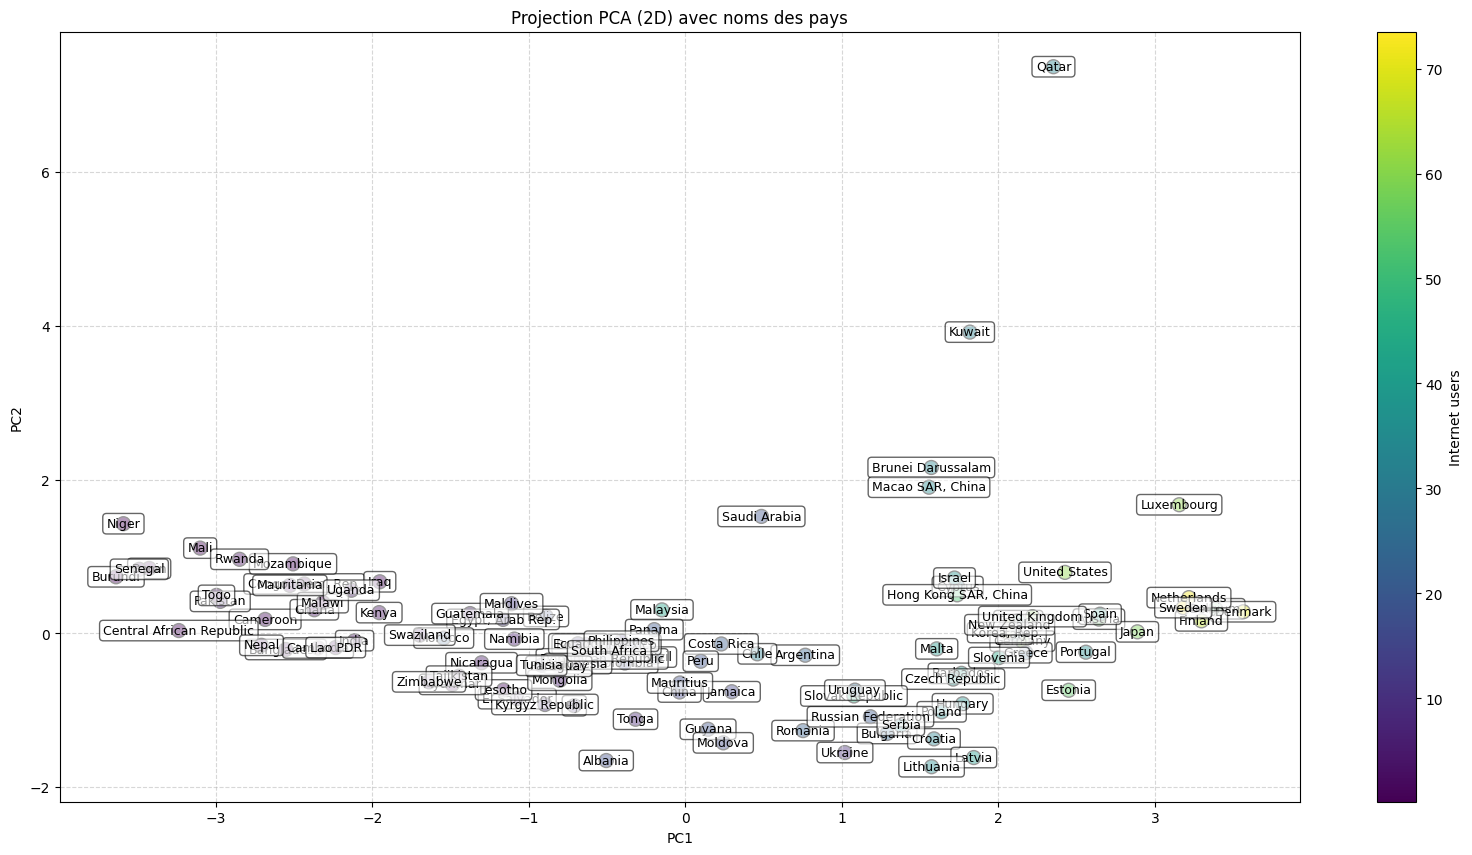

In [36]:
# Construire un DataFrame avec les composantes principales
df_pca = pd.DataFrame(
    X_pca,
    columns=['PC1', 'PC2'],
    index=df_data_final.index
)

df_pca['Internet users'] = df_data_final['Internet users (per 100 people)'].values

plt.figure(figsize=(20, 10))

# Scatter 2D
scatter = plt.scatter(
    df_pca['PC1'],
    df_pca['PC2'],
    c=df_pca['Internet users'],
    cmap='viridis',
    s=100,
    edgecolor='k'
)

# Ajouter barre de couleur
plt.colorbar(scatter, label='Internet users')

# Ajouter les noms des pays
for i, country in enumerate(df_data_final['Country Name']):
    plt.text(
        df_pca['PC1'].iloc[i],
        df_pca['PC2'].iloc[i],
        country,
        fontsize=9,
        ha='center',
        va='center',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='black', boxstyle='round,pad=0.3')
    )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Projection PCA (2D) avec noms des pays')

plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

**Interprétation du graphique**

- L'axe PC1  représente la dimension de "développement" identifiée précédemment. Les pays sur le côté droit de l'axe PC1 (valeurs positives) sont plus développés (avec un GNI per capita et un nombre d'enseignants plus élevés), tandis que ceux sur le côté gauche (valeurs négatives) le sont moins.

- La couleur des points représente le nombre d'utilisateurs d'Internet par 100 habitants. La barre de couleur à droite montre que les pays plus sombres (violet/bleu foncé) ont un faible taux d'utilisateurs d'Internet, tandis que les pays plus clairs (vert/jaune) en ont un taux élevé.

## Conclusion

Pour répondre à la problématique d'Academy, la cible se situe dans un groupe de pays qui présentent un besoin d'alternatives éducatives tout en disposant des infrastructures nécessaires pour une solution en ligne. L'analyse en composantes principales (PCA) a permis d'identifier deux dimensions clés : le niveau de développement et l'accès à Internet.

D'après le cercle de corrélation, le niveau de développement (PC1) est positivement corrélé avec l'accès à Internet et négativement corrélé avec le taux de jeunes non éduqués. Les pays les plus développés se situent sur le côté droit du graphique (PC1 > 0), où le besoin en éducation est moindre car l'offre est plus satisfaisante. Inversement, les pays moins développés se trouvent sur le côté gauche (PC1 < 0) et représentent le marché potentiel le plus pertinent en raison de leur besoin élevé en éducation.

Cependant, il est crucial de nuancer cette affirmation en considérant le taux d'utilisateurs d'Internet. Une solution en ligne n'est viable que si la population est connectée. Les pays les moins développés ont malheureusement souvent le taux d'accès à Internet le plus faible.

Pour identifier le marché idéal, il faut donc cibler un groupe de pays qui présente à la fois un besoin en éducation (PC1 < 0) et un taux d'utilisation d'Internet suffisant.

Voici une liste de 10 pays qui se situent dans la zone de besoin (PC1 < 0) et qui, par leur accès à Internet, constituent une cible pertinente pour une offre d'éducation en ligne :

In [37]:
df_pca['Country Name'] = df_data_final['Country Name'].values

In [38]:
df_pca[df_pca['PC1'] < 0].sort_values('Internet users', ascending=False).head(10)

,PC1,PC2,Internet users,Country Name
120,-0.149358,0.306064,42.104634,Malaysia
133,-1.543950,-0.061126,22.592745,Morocco
26,-0.191561,-0.307917,21.514477,Brazil
150,-0.198573,0.049128,19.379602,Panama
127,-0.318574,-0.144003,17.780461,Mexico
19,-0.889871,0.220385,17.054612,Belize
1,-0.505275,-1.653807,17.052663,Albania
126,-0.034484,-0.645268,16.927921,Mauritius
42,-0.386587,-0.385262,16.571599,Colombia
197,-0.917957,-0.414574,16.401942,Tunisia
